<a href="https://colab.research.google.com/github/IslamAlam/multi-spectral_image_classification/blob/master/multi_spectral_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## To open the latest notebook please open this [link](https://github.com/IslamAlam/multi-spectral_image_classification/blob/master/multi_spectral_image_classification.ipynb)

## Clone Repo from GIT

In [0]:
!git clone https://github.com/IslamAlam/multi-spectral_image_classification.git
!git submodule init
!git submodule update

Cloning into 'multi-spectral_image_classification'...
remote: Enumerating objects: 48, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 48 (delta 15), reused 29 (delta 6), pack-reused 0
Unpacking objects: 100% (48/48), done.
fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git


## Install Required Packages:

In [0]:
!apt install python3-rtree
!pip install Pillow
!pip install rasterio
!pip install numpy
!pip install shapely
!pip install geopandas
!pip install earthpy
!pip install descartes
#!pip install cartopy

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libspatialindex-c4v5 libspatialindex-dev libspatialindex4v5
  python3-pkg-resources
Suggested packages:
  python3-setuptools
The following NEW packages will be installed:
  libspatialindex-c4v5 libspatialindex-dev libspatialindex4v5
  python3-pkg-resources python3-rtree
0 upgraded, 5 newly installed, 0 to remove and 6 not upgraded.
Need to get 671 kB of archives.
After this operation, 3,948 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex4v5 amd64 1.8.5-5 [219 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex-c4v5 amd64 1.8.5-5 [51.7 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/main amd64 python3-pkg-

In [0]:
cd multi-spectral_image_classification/

/content/multi-spectral_image_classification


In [0]:
ls

00_nb_run.sh  environment.yml                            requirements.txt
01_main.py    multi_spectral_image_classification.ipynb
data/         pretty/


## Import libraries

In [0]:
# -*- coding: utf-8 -*-
"""
Created on Wed Mar 25 01:48:14 2019
Last modified on Wed Apr 06 2019
@author: Islam Mansour
Purpose: Reada shapefile with geopandas as a dataframe and reproject the
         shapefile.
"""
###############################################################################
# Import Packages
# ------------------------------
#
# To begin, import the needed packages. You will use a combination of several EarthPy
# modules including spatial, plot and mask.

import rasterio as rio
from rasterio.plot import show
from rasterio.mask import mask
from shapely.geometry import mapping
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib import colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import geopandas as gpd
import earthpy as et
# import cartopy as cp
import rasterio as rio
from rasterio.warp import calculate_default_transform, reproject, Resampling

import scipy
from osgeo import gdal
from skimage import exposure
from skimage.segmentation import quickshift, felzenszwalb
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier

plt.ion()
os.chdir(os.path.join(et.io.HOME, '/content/multi-spectral_image_classification'))
# optional - turn off warnings
import warnings
warnings.filterwarnings('ignore')

### Define the data path

In [0]:
#%%
RASTER_DATA_FILE = "./data/image/crop_p224r63_all_bands.tif"
TRAIN_DATA_PATH = "./data/train/"
TEST_DATA_PATH = "./data/test/"

### Define reproject_layer  to project any shapfile or GeoTiff to new_crs

In [0]:
# https://www.earthdatascience.org/courses/earth-analytics-python/lidar-raster-data/reproject-raster/
def reproject_layer(inpath, outpath, new_crs):
    '''
    * This function reprojects a raster GeoTIFF or vector (shp) to a new selected Coordinate Reference System (CRS) then
    save the reprojected GeoTIFF/shp to outpath

    PARAMETERS:
        inpath = path to orginal GeoTIFF to be reprojected/ shp; for example:
        outpath = path to save the newly reprojected GeoTIFF; for example: "data/reprojected.tif" or shp
        new_crs = required CRS projection ; for example: "epsg:4326"

    RETURNS:
        create a new reprojected GeoTIFF

    REQUIREMENTS:
        import rasterio as rio
        import os
        import earthpy as et
        import numpy as np
        from rasterio.warp import calculate_default_transform, reproject, Resampling
    '''
    dst_crs = new_crs  # CRS for web meractor

    if '.shp' in inpath:
        src = gpd.read_file(inpath)
        # Reproject the data
        data = src.to_crs(epsg=dst_crs.split('EPSG:', 1)[1])
        # Save to disk
        data.to_file(outpath)


    else:
        with rio.open(inpath) as src:
            transform, width, height = calculate_default_transform(
                src.crs, dst_crs, src.width, src.height, *src.bounds)
            kwargs = src.meta.copy()
            kwargs.update({
                'crs': dst_crs,
                'transform': transform,
                'width': width,
                'height': height
            })

            with rio.open(outpath, 'w', **kwargs) as dst:
                for i in range(1, src.count + 1):
                    reproject(
                        source=rio.band(src, i),
                        destination=rio.band(dst, i),
                        src_transform=src.transform,
                        src_crs=src.crs,
                        dst_transform=transform,
                        dst_crs=dst_crs,
                        resampling=Resampling.nearest)
#%%

# 1- Project GeoTiff and shapfiles
Reproject the image and shapefiles to the following projection:
Universal Transverse Mercator (UTM) 22 South with an WGS 84 ellipsoid.

In [0]:
# define crs
new_crs = 'EPSG:29192' # Universal Transverse Mercator (UTM) 22 South with an WGS 84 ellipsoid


# import the GeoTIFF
TIFF_INPATH = RASTER_DATA_FILE
TIFF_OUTPATH = RASTER_DATA_FILE[:-4] + '_' + new_crs.split('EPSG:', 1)[1] + RASTER_DATA_FILE[-4:]

# import the data train data
TRAIN_DATA_INPATH = (TRAIN_DATA_PATH + "train_data.shp")
TRAIN_DATA_OUTPATH = TRAIN_DATA_INPATH[:-4] + '_' + new_crs.split('EPSG:', 1)[1] + TRAIN_DATA_INPATH[-4:]

# import the test data
TEST_DATA_INPATH = (TEST_DATA_PATH + "val_data.shp")
TEST_DATA_OUTPATH = TEST_DATA_INPATH[:-4] + '_' + new_crs.split('EPSG:', 1)[1] + TEST_DATA_INPATH[-4:]

#%% Re-project
reproject_layer(TIFF_INPATH, TIFF_OUTPATH, new_crs)
reproject_layer(TEST_DATA_INPATH, TEST_DATA_OUTPATH, new_crs)
reproject_layer(TRAIN_DATA_INPATH, TRAIN_DATA_OUTPATH, new_crs)




### Check to make sure function created new files correctly

In [0]:
tiff_project = rio.open(TIFF_OUTPATH)
train_data_project = gpd.read_file(TRAIN_DATA_OUTPATH)
test_data_project = gpd.read_file(TEST_DATA_OUTPATH)

print('GeoTIFF file crs', tiff_project.crs)
print("Train shape file crs", train_data_project.crs)
print("Val shape file crs", test_data_project.crs)

GeoTIFF file crs EPSG:29192
Train shape file crs {'init': 'epsg:29192'}
Val shape file crs {'init': 'epsg:29192'}


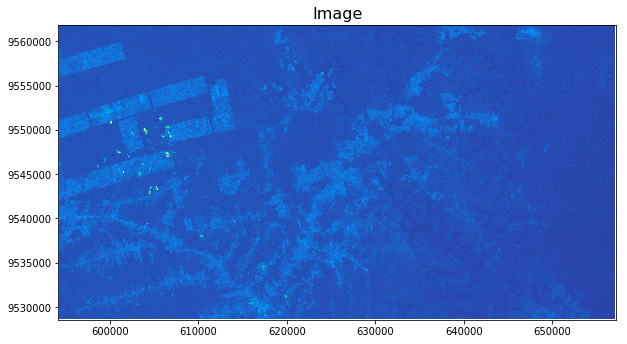

In [0]:
# open the reporjected GeoTiff file
with rio.open(TIFF_OUTPATH) as src:
    tiff_im = src.read(masked = True)[0]
    extent = rio.plot.plotting_extent(src)
    soap_profile = src.profile
fig, ax = plt.subplots(figsize=(10, 10))

show(tiff_im,
     cmap='terrain',
     ax=ax,
     extent=extent)

ax.set_title("Image",
             fontsize = 16);



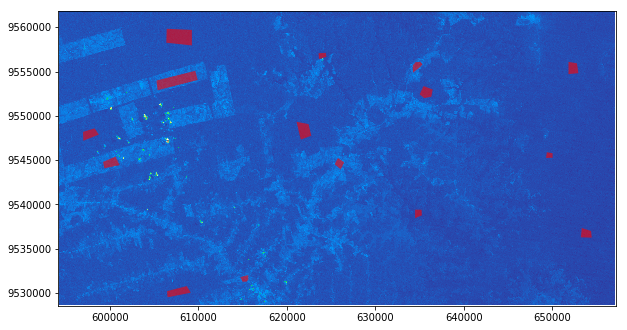

In [0]:
# Overlay shape file of train data

vector_layer = train_data_project
fig, ax = plt.subplots(figsize=(10, 10))

ax.imshow(tiff_im,
          cmap='terrain',
          extent=extent)
vector_layer.plot(ax=ax, alpha=.6, color='r')

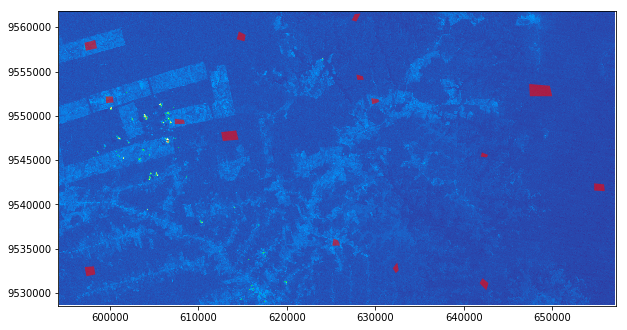

In [0]:
# Overlay shape file of train data

vector_layer = test_data_project
fig, ax = plt.subplots(figsize=(10, 10))

ax.imshow(tiff_im,
          cmap='terrain',
          extent=extent)
vector_layer.plot(ax=ax, alpha=.6, color='r')

## Challenge 2:

### Plot all bands of the image
**Afterwards, the best 3 bands with the highest contrast to distinguish between classes are chosen for segmentation**

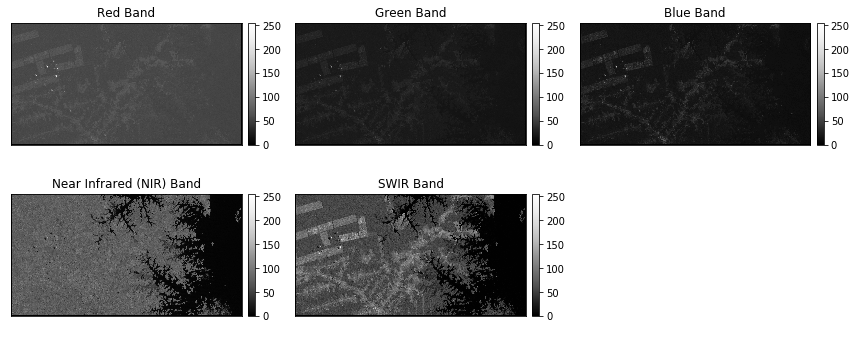

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9b90152978>,
      dtype=object)

In [0]:
import earthpy.plot as ep

with rio.open(TIFF_OUTPATH) as src:
    tiff_im = src.read()
    tiff_im_meta = src.meta

titles = ["Red Band", "Green Band", "Blue Band", "Near Infrared (NIR) Band", "SWIR Band"]

# plot all bands using the earthpy function
ep.plot_bands(tiff_im, 
              title=titles,
              figsize=(12, 5), 
              cols=3,
              scale=False,
              vmin=0,
              vmax=255)


### List all classes of the shape file:

In [0]:
print('List of classes: ',train_data_project.class_name.unique())

List of classes:  ['forest' 'deforest' 'water']


### Plot RGB Bands

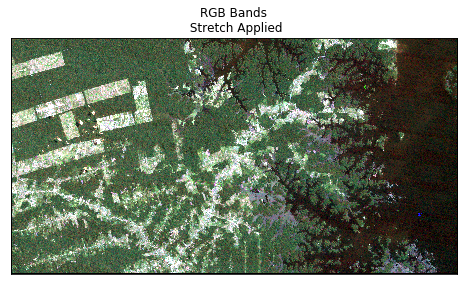

In [0]:
fig, ax = plt.subplots(figsize=(8,6))
band_indices = [0, 1, 2]

# apply stretch using the earthpy plot_rgb function
ep.plot_rgb(tiff_im,
            rgb=band_indices,
            title="RGB Bands\n Stretch Applied",
            figsize=(6, 6),
            stretch=True, ax=ax)


In [0]:
def create_mask_from_vector(vector_data_path, cols, rows, geo_transform, projection, target_value=1,
                            output_fname='', dataset_format='MEM'):
    """
    Rasterize the given vector (wrapper for gdal.RasterizeLayer). Return a gdal.Dataset.
    :param vector_data_path: Path to a shapefile
    :param cols: Number of columns of the result
    :param rows: Number of rows of the result
    :param geo_transform: Returned value of gdal.Dataset.GetGeoTransform (coefficients for
                          transforming between pixel/line (P,L) raster space, and projection
                          coordinates (Xp,Yp) space.
    :param projection: Projection definition string (Returned by gdal.Dataset.GetProjectionRef)
    :param target_value: Pixel value for the pixels. Must be a valid gdal.GDT_UInt16 value.
    :param output_fname: If the dataset_format is GeoTIFF, this is the output file name
    :param dataset_format: The gdal.Dataset driver name. [default: MEM]
    """
    
    data_source = gdal.OpenEx(vector_data_path, gdal.OF_VECTOR)
    layer = data_source.GetLayer(0)
    driver = gdal.GetDriverByName('MEM')  # In memory dataset
    target_ds = driver.Create('', cols, rows, 1, gdal.GDT_UInt16)
    target_ds.SetGeoTransform(geo_transform)
    target_ds.SetProjection(projection)
    gdal.RasterizeLayer(target_ds, [1], layer, burn_values=[target_value])
    return target_ds


def vectors_to_raster(file_paths, rows, cols, geo_transform, projection):
    """
    Rasterize, in a single image, all the vectors in the given directory.
    The data of each file will be assigned the same pixel value. This value is defined by the order
    of the file in file_paths, starting with 1: so the points/poligons/etc in the same file will be
    marked as 1, those in the second file will be 2, and so on.
    :param file_paths: Path to a directory with shapefiles
    :param rows: Number of rows of the result
    :param cols: Number of columns of the result
    :param geo_transform: Returned value of gdal.Dataset.GetGeoTransform (coefficients for
                          transforming between pixel/line (P,L) raster space, and projection
                          coordinates (Xp,Yp) space.
    :param projection: Projection definition string (Returned by gdal.Dataset.GetProjectionRef)
    """
    labeled_pixels = np.zeros((rows, cols))
    for i, path in enumerate(file_paths):
        label = i+1
        ds = create_mask_from_vector(path, cols, rows, geo_transform,
                                     projection, target_value=label)
        band = ds.GetRasterBand(1)
        labeled_pixels += band.ReadAsArray()
        ds = None
    return labeled_pixels

def raster_to_npndarray(file_path, str_clip=2):
    """Stretch an image in numpy ndarray format using a specified clip value.
    Parameters
    ----------
    file_path: dir
        Path to a directory for raster image
    str_clip: int
        The % of clip to apply to the stretch. Default = 2 (2 and 98)
    Returns
    ----------
    bands_data: 
      numpy array with values stretched to the specified clip % for each band
    n_bands:
      Number of bandes in the raster image
    geo_transform: Returned value of gdal.Dataset.GetGeoTransform (coefficients for
                          transforming between pixel/line (P,L) raster space, and projection
                          coordinates (Xp,Yp) space.: 
    
    projection: Projection definition string (Returned by gdal.Dataset.GetProjectionRef)
    """
  
    raster_dataset = gdal.Open(file_path, gdal.GA_ReadOnly)
    n_bands = raster_dataset.RasterCount
    geo_transform = raster_dataset.GetGeoTransform()
    projection = raster_dataset.GetProjectionRef()
    bands_data = np.zeros_like(raster_dataset.ReadAsArray())


    # Stretch an image in numpy ndarray format using a specified clip value.
    str_clip = 2
    s_min = str_clip
    s_max = 100 - str_clip

    for b in range(1, n_bands+1):
        band = raster_dataset.GetRasterBand(b).ReadAsArray()
        lower, upper = np.percentile(band, (s_min, s_max))

        # Return image after stretching or shrinking its intensity levels.
        bands_data [b-1] = exposure.rescale_intensity(
                band, in_range=(lower, upper))

    bands_data = np.dstack(b for b in bands_data)
    return bands_data, n_bands, geo_transform, projection



In [0]:

# Convert bands to numpy arrays for processing
bands_data, n_bands, geo_transform, proj = raster_to_npndarray(TIFF_OUTPATH)

### Create RBG image for segmentation


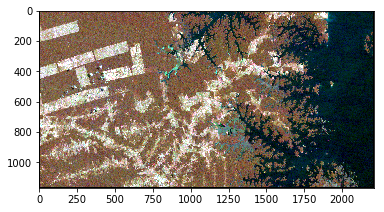

In [0]:
img = bands_data

rgb_img = np.dstack([img[:, :, 4], img[:, :, 1], img[:, :, 0]])
plt.figure()
plt.imshow(rgb_img)

In [0]:
segments_quick = quickshift(img.astype(np.double), kernel_size=7, max_dist=3, ratio=0.35, convert2lab=False)
n_segments = len(np.unique(segments_quick))
print("No of quick segments: ", n_segments)

No of quick segments:  54970


In [0]:
'''
cmap = colors.ListedColormap(np.random.rand(n_segments, 3))
plt.figure()
plt.imshow(segments_quick, interpolation='none', cmap=cmap)
'''

"\ncmap = colors.ListedColormap(np.random.rand(n_segments, 3))\nplt.figure()\nplt.imshow(segments_quick, interpolation='none', cmap=cmap)\n"


skimage.segmentation.felzenszwalb is not prepared to work with multi-band data. So, based on their own implementation for RGB images, I apply the segmentation in each band and then combine the results. See: http://github.com/scikit-image/scikit-image/blob/v0.12.3/skimage/segmentation/_felzenszwalb.py#L69

In [0]:
band_segmentation = []
for i in range(n_bands):
    band_segmentation.append(felzenszwalb(img[:, :, i], scale=100, sigma=0.5, min_size=50))

put pixels in same segment only if in the same segment in all bands. We do this by combining the band segmentation to one number


In [0]:
const = [b.max() + 1 for b in band_segmentation]
segmentation = band_segmentation[0]
for i, s in enumerate(band_segmentation[1:]):
    segmentation += s * np.prod(const[:i+1])

_, labels = np.unique(segmentation, return_inverse=True)
segments_felz = labels.reshape(img.shape[:2])

In [0]:
print("Felsenszwalb segmentation: %i segments." % len(np.unique(segments_felz)))

Felsenszwalb segmentation: 197589 segments.


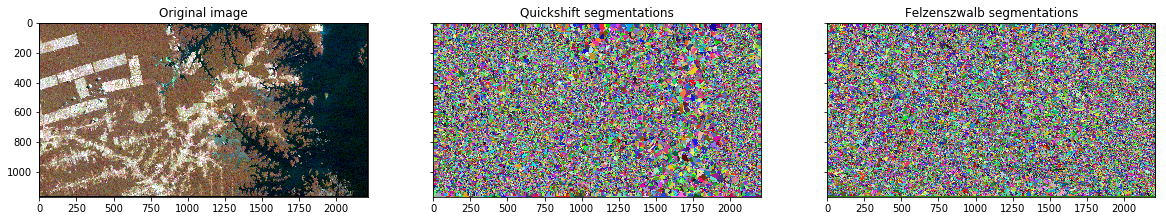

In [0]:
n_segments = max(len(np.unique(s)) for s in [segments_quick, segments_felz])
cmap = colors.ListedColormap(np.random.rand(n_segments, 3))
#SHOW_IMAGES:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(20, 26))
ax1.imshow(rgb_img, interpolation='none')
ax1.set_title('Original image')
ax2.imshow(segments_quick, interpolation='none', cmap=cmap)
ax2.set_title('Quickshift segmentations')
ax3.imshow(segments_felz, interpolation='none', cmap=cmap)
ax3.set_title('Felzenszwalb segmentations')
plt.show()

In [0]:
# We choose the quick segmentation
segments = segments_felz
segments = segments_quick
segment_ids = np.unique(segments)
print("Quickshift segmentation. %i segments." % len(segment_ids))

Quickshift segmentation. 54970 segments.


In [0]:
def create_classes(shp_file_path):
  import re
  curr_path = re.sub('\w*.shp', '', shp_file_path)
  folder = curr_path + 'classes/'
  shp_file = gpd.read_file(shp_file_path)
  class_path = []
  
  for name in shp_file.class_name.unique():
    i = 0
    if not os.path.exists(folder):
      os.makedirs(folder)
    path = folder + name + '.shp'
    class_path.append(path)
    class_data = shp_file.loc[shp_file['class_name'] == name]
    class_data.to_file((path))
    i += 1
  
  return class_path

In [0]:
rows, cols, n_bands = img.shape
create_classes(TRAIN_DATA_OUTPATH)
files = [f for f in os.listdir(TRAIN_DATA_PATH + 'classes/') if f.endswith('.shp')]
classes_labels = [f.split('.')[0] for f in files]
shapefiles = [os.path.join(TRAIN_DATA_PATH + 'classes/', f) for f in files if f.endswith('.shp')]
print(shapefiles)

['./data/train/classes/deforest.shp', './data/train/classes/water.shp', './data/train/classes/forest.shp']


In [0]:
ground_truth = vectors_to_raster(shapefiles, rows, cols, geo_transform, proj)


In [0]:
classes = np.unique(ground_truth)[1:]  # 0 doesn't count
len(classes)

3

In [0]:
segments_per_klass = {}
for klass in classes:
    segments_of_klass = segments[ground_truth==klass]
    segments_per_klass[klass] = set(segments_of_klass)
    print("Training segments for class %i: %i" % (klass, len(segments_per_klass[klass])))

Training segments for class 1: 362
Training segments for class 2: 157
Training segments for class 3: 644


## Disambiguation

Check if there are segments which contain training pixels of different classes.

In [0]:
accum = set()
intersection = set()
for class_segments in segments_per_klass.values():
    intersection |= accum.intersection(class_segments)
    accum |= class_segments
assert len(intersection) == 0

### ¡No need to disambiguate!

Next, we will paint in black all segments that are not for training. The training segments will be painted of a color depending on the class.

To do that we'll set as threshold the max segment id (max segments image pixel value). Then, to the training segments we'll assign values higher than the threshold. Finally, we assign 0 (zero) to pixels with values equal or below the threshold.

In [0]:
train_img = np.copy(segments)
threshold = train_img.max() + 1
for klass in classes:
    klass_label = threshold + klass
    for segment_id in segments_per_klass[klass]:
        train_img[train_img == segment_id] = klass_label
train_img[train_img <= threshold] = 0
train_img[train_img > threshold] -= threshold

### Lets see the training segments

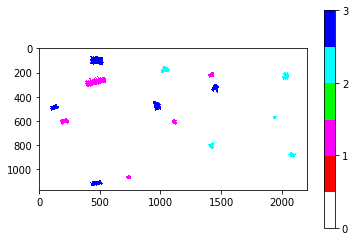

In [0]:
plt.figure()
cm = np.array([[ 1,  1,  1 ], [ 1,0,0], [ 1,0,1], [ 0,1,0], [ 0,1,1], [ 0,0,1]])
cmap = colors.ListedColormap(cm)
plt.imshow(train_img, cmap=cmap)
plt.colorbar(ticks=[0,1,2,3,4,5])

# Training data

So now, we transform each training segment into a segment model and thus creating the training dataset.

In [0]:
def segment_features(segment_pixels):
    """For each band, compute: min, max, mean, variance, skewness, kurtosis"""
    features = []
    n_pixels, n_bands = segment_pixels.shape
    for b in range(n_bands):
        stats = scipy.stats.describe(segment_pixels[:,b])
        band_stats = list(stats.minmax) + list(stats)[2:]
        if n_pixels == 1:
            # scipy.stats.describe raises a Warning and sets variance to nan
            band_stats[3] = 0.0  # Replace nan with something (zero)
        features += band_stats
    return features

In [0]:
# This is the most heavy part of the process. It could take about half an hour to finish in a not-so-fast CPU
import warnings


with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    objects = []
    objects_ids = []
    for segment_label in segment_ids:
        segment_pixels = img[segments==segment_label]
        segment_model = segment_features(segment_pixels)
        objects.append(segment_model)
        # Keep a reference to the segment label
        objects_ids.append(segment_label)

    print("Created %i objects" % len(objects))

Created 54970 objects


In [0]:
training_labels = []
training_objects = []
for klass in classes:
    class_train_objects = [v for i, v in enumerate(objects) if objects_ids[i] in segments_per_klass[klass]]
    training_labels += [klass] * len(class_train_objects)
    print("Training samples for class %i: %i" % (klass, len(class_train_objects)))
    training_objects += class_train_objects

Training samples for class 1: 362
Training samples for class 2: 157
Training samples for class 3: 644


In [0]:
classifier = RandomForestClassifier(n_jobs=-1)



In [0]:
classifier.fit(training_objects, training_labels)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [0]:
predicted = classifier.predict(objects)


In [0]:
clf = np.copy(segments)

In [0]:
for segment_id, klass in zip(objects_ids, predicted):
    clf[clf==segment_id] = klass

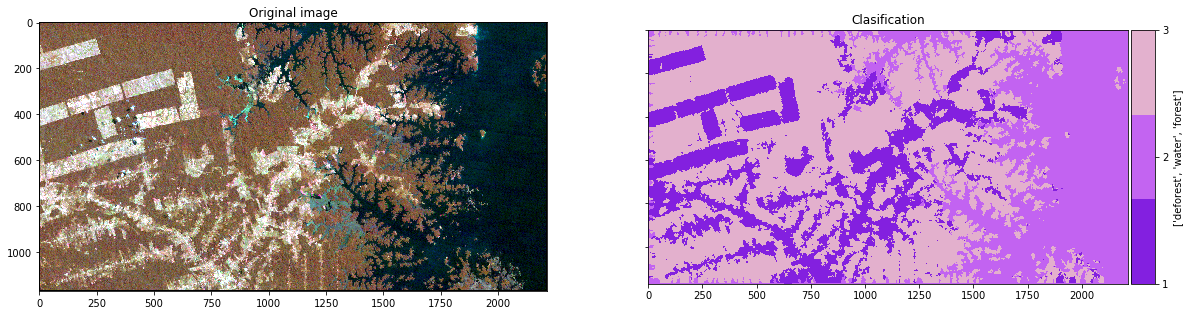

In [0]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(20, 26))
ax1.imshow(rgb_img, interpolation='none')
ax1.set_title('Original image')
img2 = ax2.imshow(clf, interpolation='none', cmap=colors.ListedColormap(np.random.rand(len(classes_labels), 3)), label=classes_labels)
ax2.set_title('Clasification')
ax = f.gca()
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
f.colorbar(img2, cax=cax, ticks=[0,1,2,3,4,5], label=classes_labels)

# Classification validation


In [0]:
rows, cols, n_bands = img.shape
create_classes(TEST_DATA_PATH)
shapefiles = [os.path.join(TEST_DATA_PATH + 'classes/', "%s.shp"%c) for c in classes_labels]
verification_pixels = vectors_to_raster(shapefiles, rows, cols, geo_transform, proj)
for_verification = np.nonzero(verification_pixels)
print(shapefiles)

['./data/test/classes/deforest.shp', './data/test/classes/water.shp', './data/test/classes/forest.shp']


In [0]:
verification_labels = verification_pixels[for_verification]
predicted_labels = clf[for_verification]

In [0]:
cm = metrics.confusion_matrix(verification_labels, predicted_labels)


In [0]:
def print_cm(cm, labels):
    """pretty print for confusion matrixes"""
    # https://gist.github.com/ClementC/acf8d5f21fd91c674808
    columnwidth = max([len(x) for x in labels])
    # Print header
    print(" " * columnwidth, end="\t")
    for label in labels:
        print("%{0}s".format(columnwidth) % label, end="\t")
    print()
    # Print rows
    for i, label1 in enumerate(labels):
        print("%{0}s".format(columnwidth) % label1, end="\t")
        for j in range(len(labels)):
            print("%{0}d".format(columnwidth) % cm[i, j], end="\t")
        print()

In [0]:
print_cm(cm, classes_labels)

        	deforest	   water	  forest	
deforest	    3996	       0	       0	
   water	       0	    6693	       0	
  forest	       0	       0	    5360	


In [0]:

print("Classification accuracy: %f" %
      metrics.accuracy_score(verification_labels, predicted_labels))

Classification accuracy: 1.000000


### Plot confusion matrix using pretty print

In [0]:
!git submodule init
!git submodule update
!git submodule update --recursive --remote


Submodule path 'pretty': checked out '7fda76f74598f07db0a9919192458ec06ca7d5b6'


In [0]:
!ls pretty # check __init__.py

confusion_matrix_pretty_print.py  LICENSE      README.md
__init__.py			  __pycache__  Screenshots


/content/multi-spectral_image_classification/pretty


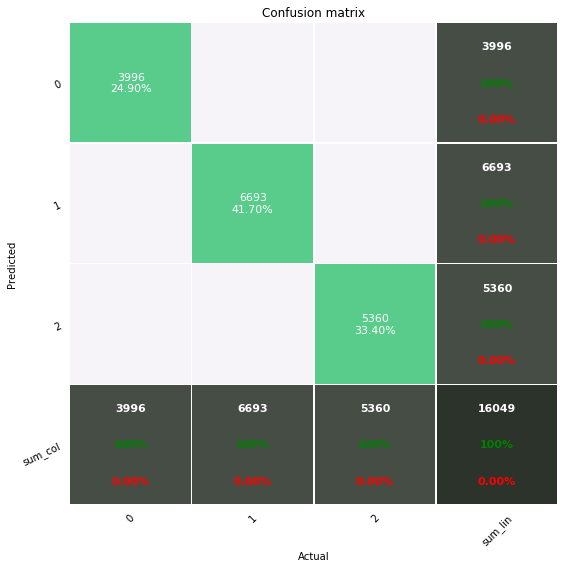

In [0]:
import sys
import pandas as pd 

path = 'pretty'
pretty_path = os.path.abspath(os.path.join(os.getcwd(), path))
print(pretty_path)

if pretty_path not in sys.path:
    sys.path.append(pretty_path)
    
from pretty.confusion_matrix_pretty_print import pretty_plot_confusion_matrix, plot_confusion_matrix_from_data

#get pandas dataframe
df_cm = pd.DataFrame(cm ) #, index=range(1,7), columns=range(1,7))
#colormap: see this and choose your more dear
cmap = 'PuRd'
pretty_plot_confusion_matrix(df_cm, cmap=cmap)

In [0]:
print("Classification report:\n%s" %
      metrics.classification_report(verification_labels, predicted_labels,
                                    target_names=classes_labels))

Classification report:
              precision    recall  f1-score   support

    deforest       1.00      1.00      1.00      3996
       water       1.00      1.00      1.00      6693
      forest       1.00      1.00      1.00      5360

   micro avg       1.00      1.00      1.00     16049
   macro avg       1.00      1.00      1.00     16049
weighted avg       1.00      1.00      1.00     16049

